## 2. Used data and source of the data.

In [1]:
import pandas as pd

### Geocoder to get coordinates of each district

In [2]:
# List with each district

districtList = ["Centro", "Arganzuela", "Retiro",
                "Salamanca", "Chamartín", "Tetuán", "Chamberí", "Fuencarral-El Pardo",
               "Moncloa-Aravaca", "Latina", "Carabanchel", "Usera", "Puente de Vallecas",
               "Moratalaz", "Ciudad Lineal", "Hortaleza", "Villaverde", "Villa de Vallecas",
               "Vicálvaro", "San Blas - Canillejas", "Barajas"]

In [3]:
import geocoder # import geocoder

In [4]:
# Create empty lists to add information about the districts
District_Number = []
District = []
Latitude = []
Longitude = []

# Start iterating each district and appendig information to the lists
for index, district in enumerate(districtList):
    g = geocoder.osm(district + ", Madrid")

    # Ensure that the returned district is the same that the one we have requested
    if districtList[index] != g.json["district"]:
        print(f"Error with {district}")  
    
    #Append to the different lists
    District_Number.append(index+1)
    District.append(g.json["district"])
    Latitude.append(g.json["lat"])
    Longitude.append(g.json["lng"])

# Create DataFrame
df = pd.DataFrame({"District_Number": District_Number,
                   "District": District,
                   "Latitude": Latitude,
                   "Longitude": Longitude})

In [5]:
df.head()

,District_Number,District,Latitude,Longitude
0,1,Centro,40.417552,-3.707941
1,2,Arganzuela,40.398068,-3.693734
2,3,Retiro,40.408155,-3.677441
3,4,Salamanca,40.431527,-3.674726
4,5,Chamartín,40.460764,-3.677534


In [6]:
g = geocoder.osm("Arganzuela, Madrid")

### Draw a map with the coordinates

In [7]:
import folium

In [8]:
map_madrid = folium.Map(location=[Latitude[0], Longitude[0]], zoom_start=11)

for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid) 

map_madrid

### SquareSpace

In [9]:
import requests

#### Credentials

In [10]:
CLIENT_ID = 'TIPPCABA5N3LHBQXI1A50YVKL5BYEAVT5ZYQVMZNITAZSMW1' # your Foursquare ID
CLIENT_SECRET = 'GPQKLXTIB3O5LKPZVWAQKEW5YX45ASBRPMTF0EJ1ULAKC4G5' # your Foursquare Secret
VERSION = '20200202' # Foursquare API version
LIMIT = 100
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Get Top Venues of each district

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
madrid_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [13]:
madrid_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.417552,-3.707941,TOC Hostel,40.417264,-3.705928,Hostel
1,Centro,40.417552,-3.707941,Plaza de Isabel II,40.418114,-3.709397,Plaza
2,Centro,40.417552,-3.707941,Plaza Mayor,40.415527,-3.707506,Plaza
3,Centro,40.417552,-3.707941,Amorino,40.416065,-3.708383,Ice Cream Shop
4,Centro,40.417552,-3.707941,Mistura Ice Cream & Coffee,40.415771,-3.708441,Ice Cream Shop


#### Get GYMs of each district

In [14]:
def getCategoryVenues(names, latitudes, longitudes, search_query, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
            
            
        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
        
        # return only relevant information for each nearby venue
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  search_query, 
                  search_query+'_Latitude', 
                  search_query+'_Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
madrid_gyms = getCategoryVenues(names=df['District'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'],
                                search_query = 'gym'
                               )

In [16]:
madrid_gyms.head()

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
0,Centro,40.417552,-3.707941,The Cellar Gym,40.420685,-3.707365,Gym / Fitness Center
1,Centro,40.417552,-3.707941,Myst Gym Club,40.416477,-3.705330,Gym
2,Centro,40.417552,-3.707941,Gym @ Hotel Liabeny,40.418476,-3.703958,Gym / Fitness Center
3,Centro,40.417552,-3.707941,Gym @ Hyatt Centric,40.419985,-3.703762,Gym / Fitness Center
4,Centro,40.417552,-3.707941,Pestana Gym,40.414791,-3.707039,Gym / Fitness Center


**We now have three dataframes:**

In [17]:
print(f"Madrid Districts --> Rows:  {df.shape[0]}  Columns: {df.shape[1]}\n")
df.head()

Madrid Districts --> Rows:  21  Columns: 4



,District_Number,District,Latitude,Longitude
0,1,Centro,40.417552,-3.707941
1,2,Arganzuela,40.398068,-3.693734
2,3,Retiro,40.408155,-3.677441
3,4,Salamanca,40.431527,-3.674726
4,5,Chamartín,40.460764,-3.677534


In [18]:
print(f"Madrid Venues --> Rows:  {madrid_venues.shape[0]}  Columns: {madrid_venues.shape[1]}\n")
madrid_venues.head()

Madrid Venues --> Rows:  1038  Columns: 7



,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,40.417552,-3.707941,TOC Hostel,40.417264,-3.705928,Hostel
1,Centro,40.417552,-3.707941,Plaza de Isabel II,40.418114,-3.709397,Plaza
2,Centro,40.417552,-3.707941,Plaza Mayor,40.415527,-3.707506,Plaza
3,Centro,40.417552,-3.707941,Amorino,40.416065,-3.708383,Ice Cream Shop
4,Centro,40.417552,-3.707941,Mistura Ice Cream & Coffee,40.415771,-3.708441,Ice Cream Shop


In [19]:
print(f"Madrid Gyms --> Rows:  {madrid_gyms.shape[0]}  Columns: {madrid_gyms.shape[1]}\n")
madrid_gyms.head()

Madrid Gyms --> Rows:  77  Columns: 7



,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
0,Centro,40.417552,-3.707941,The Cellar Gym,40.420685,-3.707365,Gym / Fitness Center
1,Centro,40.417552,-3.707941,Myst Gym Club,40.416477,-3.705330,Gym
2,Centro,40.417552,-3.707941,Gym @ Hotel Liabeny,40.418476,-3.703958,Gym / Fitness Center
3,Centro,40.417552,-3.707941,Gym @ Hyatt Centric,40.419985,-3.703762,Gym / Fitness Center
4,Centro,40.417552,-3.707941,Pestana Gym,40.414791,-3.707039,Gym / Fitness Center


## 3. Methodology

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Exploring and Cleaning Data

#### Top places in Madrid and top places per district

In [21]:
print(f'There are {len(madrid_venues["Venue Category"].unique())} unique categories.')

There are 182 unique categories.


In [22]:
df_topMadridVenues = madrid_venues["Venue Category"].value_counts()
df_topMadridVenues = df_topMadridVenues.reset_index()
df_topMadridVenues.rename(columns={"index":"Category", "Venue Category":"Number"}, inplace = True)
df_topMadridVenues.set_index("Category", inplace=True)

**Top Venues in Madrid**

In [23]:
df_topMadridVenues.head(15)

,Number
Category,
Spanish Restaurant,126
Restaurant,61
Tapas Restaurant,46
Bar,39
Grocery Store,28
Hotel,27
Café,26
Plaza,25
Bakery,23


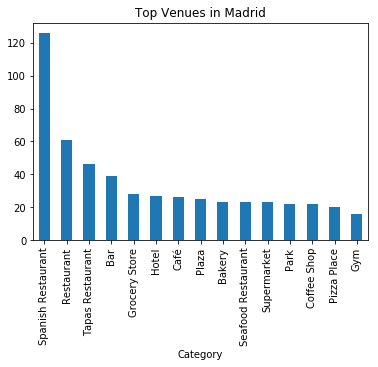

In [24]:
df_topMadridVenues.head(15).plot.bar()
plt.title("Top Venues in Madrid")
plt.legend().set_visible(False)
plt.show()

**Top Venues in Madrid by district**

In [25]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
madrid_onehot['District'] = madrid_venues['District'] 

# move Neighbourhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head()

,District,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tattoo Parlor,Thai Restaurant,Theater,Theme Restaurant,Track Stadium,Trade School,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Centro,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
madrid_onehot.shape

(1038, 183)

#### Next, let's group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category

In [27]:
madrid_grouped = madrid_onehot.groupby('District').mean().reset_index()
madrid_grouped.head()

,District,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Tattoo Parlor,Thai Restaurant,Theater,Theme Restaurant,Track Stadium,Trade School,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,Arganzuela,0.000000,0.000000,0.00,0.00,0.02,0.020000,0.02,0.01,0.01,...,0.01,0.01,0.00,0.01,0.0,0.01,0.01,0.00,0.00,0.010000
1,Barajas,0.066667,0.033333,0.00,0.00,0.00,0.033333,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.033333
2,Carabanchel,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.000000
3,Centro,0.000000,0.000000,0.01,0.00,0.00,0.000000,0.00,0.02,0.00,...,0.00,0.00,0.03,0.00,0.0,0.00,0.00,0.00,0.01,0.010000
4,Chamartín,0.000000,0.000000,0.01,0.01,0.00,0.010000,0.00,0.00,0.01,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.000000


#### Let's confirm the new size

In [28]:
madrid_grouped.shape

(20, 183)

In [29]:
num_top_venues = 5

for hood in madrid_grouped['District']:
    temp = madrid_grouped[madrid_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each Neighbourhood.

In [31]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_venues_sorted = pd.DataFrame(columns=columns)
District_venues_sorted['District'] = madrid_grouped['District']

for ind in np.arange(madrid_grouped.shape[0]):
    District_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

District_venues_sorted.head(21)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arganzuela,Restaurant,Spanish Restaurant,Grocery Store,Tapas Restaurant,Coffee Shop
1,Barajas,Hotel,Spanish Restaurant,Airport,Tapas Restaurant,Restaurant
2,Carabanchel,Tapas Restaurant,Bakery,Grocery Store,Pizza Place,Café
3,Centro,Plaza,Spanish Restaurant,Tapas Restaurant,Hotel,Café
4,Chamartín,Spanish Restaurant,Restaurant,Plaza,Mediterranean Restaurant,Coffee Shop
5,Chamberí,Spanish Restaurant,Tapas Restaurant,Café,Bar,Restaurant
6,Ciudad Lineal,Spanish Restaurant,Grocery Store,Park,Restaurant,Chinese Restaurant
7,Hortaleza,Spanish Restaurant,Tapas Restaurant,Supermarket,Restaurant,Pool
8,Latina,Metro Station,Bar,Train Station,Convenience Store,Smoke Shop
9,Moncloa-Aravaca,Park,Hookah Bar,Track Stadium,Gym / Fitness Center,Coffee Shop


We have 20 districts when initially there where 21. This is because District "Fuencarral-El Pardo" has no venues. This is normal as this district is mostly occupied by a natural park.

In [32]:
madrid_venues.loc[madrid_venues["District"] == "Fuencarral-El Pardo"]

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


#### Exploring GYMs Venues

In [33]:
madrid_gyms.head()

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
0,Centro,40.417552,-3.707941,The Cellar Gym,40.420685,-3.707365,Gym / Fitness Center
1,Centro,40.417552,-3.707941,Myst Gym Club,40.416477,-3.705330,Gym
2,Centro,40.417552,-3.707941,Gym @ Hotel Liabeny,40.418476,-3.703958,Gym / Fitness Center
3,Centro,40.417552,-3.707941,Gym @ Hyatt Centric,40.419985,-3.703762,Gym / Fitness Center
4,Centro,40.417552,-3.707941,Pestana Gym,40.414791,-3.707039,Gym / Fitness Center


In [34]:
madrid_gyms.shape

(77, 7)

In [35]:
dropCategories = madrid_gyms["Venue Category"].unique()

In [36]:
dropCategories

array(['Gym / Fitness Center', 'Gym', 'Nightclub', 'Hotel',
       'Salon / Barbershop', 'Other Nightlife', 'Restaurant',
       'Beer Garden', 'Gymnastics Gym', 'General Entertainment',
       'Supplement Shop', 'Coworking Space', 'Bike Shop',
       'Athletics & Sports', 'Pool',
       'Residential Building (Apartment / Condo)', 'College Gym',
       'Sports Club', 'Dog Run'], dtype=object)

In [37]:
dropCategories = np.delete(dropCategories, 0)
dropCategories = np.delete(dropCategories, 0)
dropCategories = np.delete(dropCategories, 6)
dropCategories = np.delete(dropCategories, 10)
dropCategories = np.delete(dropCategories, 12)
dropCategories = np.delete(dropCategories, 12)

In [38]:
dropCategories

array(['Nightclub', 'Hotel', 'Salon / Barbershop', 'Other Nightlife',
       'Restaurant', 'Beer Garden', 'General Entertainment',
       'Supplement Shop', 'Coworking Space', 'Bike Shop', 'Pool',
       'Residential Building (Apartment / Condo)', 'Dog Run'],
      dtype=object)

In [39]:
toDrop = madrid_gyms[madrid_gyms["Venue Category"].isin(dropCategories)]

In [40]:
toDrop

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
6,Centro,40.417552,-3.707941,The Gym @ Ohm,40.421685,-3.713022,Nightclub
13,Centro,40.417552,-3.707941,DoubleTree by Hilton,40.415197,-3.696738,Hotel
14,Centro,40.417552,-3.707941,Gymage,40.421278,-3.704796,Salon / Barbershop
15,Centro,40.417552,-3.707941,Gymage,40.412144,-3.706249,Other Nightlife
16,Centro,40.417552,-3.707941,Gymage Theater,40.421127,-3.702011,Restaurant
17,Centro,40.417552,-3.707941,Terraza Gymage,40.421438,-3.704736,Beer Garden
34,Salamanca,40.431527,-3.674726,Gym Hermosilla 56,40.426059,-3.680907,General Entertainment
35,Salamanca,40.431527,-3.674726,NOVU Skin Gym,40.426028,-3.676213,Supplement Shop
44,Salamanca,40.431527,-3.674726,zanox Hispania,40.429128,-3.674989,Coworking Space
48,Chamartín,40.460764,-3.677534,Bicicleta Holiday Gym,40.458514,-3.679297,Bike Shop


Clearly some of those are gyms but are not correctly classified. We need to manually specify which rows to drop.

In [41]:
indextodrop = [6,13,14,15,16,17,48,52]

In [42]:
madrid_gyms.drop(indextodrop, axis=0, inplace=True)

In [43]:
madrid_gyms.head()

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
0,Centro,40.417552,-3.707941,The Cellar Gym,40.420685,-3.707365,Gym / Fitness Center
1,Centro,40.417552,-3.707941,Myst Gym Club,40.416477,-3.705330,Gym
2,Centro,40.417552,-3.707941,Gym @ Hotel Liabeny,40.418476,-3.703958,Gym / Fitness Center
3,Centro,40.417552,-3.707941,Gym @ Hyatt Centric,40.419985,-3.703762,Gym / Fitness Center
4,Centro,40.417552,-3.707941,Pestana Gym,40.414791,-3.707039,Gym / Fitness Center


Let's delete duplicate gyms

In [44]:
madrid_gyms.drop_duplicates(subset=["gym_Latitude", "gym_Longitude"], inplace=True)

In [45]:
madrid_gyms.head()

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
0,Centro,40.417552,-3.707941,The Cellar Gym,40.420685,-3.707365,Gym / Fitness Center
1,Centro,40.417552,-3.707941,Myst Gym Club,40.416477,-3.705330,Gym
2,Centro,40.417552,-3.707941,Gym @ Hotel Liabeny,40.418476,-3.703958,Gym / Fitness Center
3,Centro,40.417552,-3.707941,Gym @ Hyatt Centric,40.419985,-3.703762,Gym / Fitness Center
4,Centro,40.417552,-3.707941,Pestana Gym,40.414791,-3.707039,Gym / Fitness Center


In [46]:
madrid_gyms.shape

(67, 7)

This is our final gym dataframe.

Gyms in a map:

In [47]:
map_gyms = folium.Map(location=[Latitude[0], Longitude[0]], zoom_start=11)

for lat, lng, label in zip(madrid_gyms['gym_Latitude'], madrid_gyms['gym_Longitude'], madrid_gyms['gym']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gyms) 

map_gyms

**Let's combine districts and gyms in a map**

In [48]:
distritos_geo = r"distritos.geojson"

In [49]:
distritos_geo

'distritos.geojson'

In [50]:
folium.GeoJson(
    distritos_geo
).add_to(map_gyms)

In [51]:
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_gyms) 
map_gyms

### Gyms per District

In [52]:
madrid_gyms.groupby("District").count()

,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
District,,,,,,
Arganzuela,5,5,5,5,5,5
Centro,12,12,12,12,12,12
Chamartín,6,6,6,6,6,6
Chamberí,10,10,10,10,10,10
Ciudad Lineal,2,2,2,2,2,2
Latina,1,1,1,1,1,1
Moncloa-Aravaca,1,1,1,1,1,1
Puente de Vallecas,1,1,1,1,1,1
Retiro,5,5,5,5,5,5


### Cluster Districts

In [53]:
from sklearn.cluster import KMeans


# set number of clusters
kclusters = 10
madrid_grouped_clustering = madrid_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:]

array([5, 7, 9, 5, 3, 3, 3, 3, 6, 4, 9, 0, 5, 3, 5, 3, 3, 2, 1, 8],
      dtype=int32)

In [54]:
# add clustering labels
District_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each Neighbourhood
madrid_merged = madrid_merged.join(District_venues_sorted.set_index('District'), on='District')

madrid_merged.dropna(inplace=True)

madrid_merged.head() # check the last columns!

,District_Number,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Centro,40.417552,-3.707941,5.0,Plaza,Spanish Restaurant,Tapas Restaurant,Hotel,Café
1,2,Arganzuela,40.398068,-3.693734,5.0,Restaurant,Spanish Restaurant,Grocery Store,Tapas Restaurant,Coffee Shop
2,3,Retiro,40.408155,-3.677441,5.0,Bar,Spanish Restaurant,Bakery,Supermarket,Museum
3,4,Salamanca,40.431527,-3.674726,3.0,Spanish Restaurant,Restaurant,Seafood Restaurant,Indian Restaurant,Supermarket
4,5,Chamartín,40.460764,-3.677534,3.0,Spanish Restaurant,Restaurant,Plaza,Mediterranean Restaurant,Coffee Shop


In [55]:
madrid_merged["Cluster Labels"] = madrid_merged["Cluster Labels"].astype(int)

In [56]:
madrid_merged.dropna(inplace=True)

In [57]:
madrid_merged["Cluster Labels"].unique()

array([5, 3, 4, 6, 9, 0, 8, 1, 2, 7])

In [58]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[Latitude[0], Longitude[0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['District'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [59]:
cluster0 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [60]:
cluster1 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [61]:
cluster2 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [62]:
cluster3 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [63]:
cluster4 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [64]:
cluster5 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 5, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [65]:
cluster6 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 6, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [66]:
cluster7 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 7, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [67]:
cluster8 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 8, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

In [68]:
cluster9 = madrid_merged.loc[madrid_merged['Cluster Labels'] == 9, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

### Gyms in each cluster

#### Cluster 0

In [69]:
cluster0

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Puente de Vallecas,Supermarket,Bar,Grocery Store,Clothing Store,Park


In [70]:
madrid_gyms[madrid_gyms["District"].isin(cluster0["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
74,Puente de Vallecas,40.383553,-3.654535,Palomeras Gym,40.385078,-3.65304,Gym / Fitness Center


**Number of Gyms: 1**

#### Cluster 1

In [71]:
cluster1

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Villa de Vallecas,Shoe Store,Wine Bar,Dumpling Restaurant,Flea Market,Fish Market


In [72]:
madrid_gyms[madrid_gyms["District"].isin(cluster1["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category


**Number of Gyms: 0**

#### Cluster 2

In [73]:
cluster2

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Vicálvaro,Mediterranean Restaurant,Wine Bar,Eastern European Restaurant,Food,Flea Market


In [74]:
madrid_gyms[madrid_gyms["District"].isin(cluster2["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category


**Number of Gyms: 0**

#### Cluster 3

In [75]:
cluster3

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Salamanca,Spanish Restaurant,Restaurant,Seafood Restaurant,Indian Restaurant,Supermarket
4,Chamartín,Spanish Restaurant,Restaurant,Plaza,Mediterranean Restaurant,Coffee Shop
5,Tetuán,Spanish Restaurant,Restaurant,Tapas Restaurant,Seafood Restaurant,Hotel
6,Chamberí,Spanish Restaurant,Tapas Restaurant,Café,Bar,Restaurant
11,Usera,Spanish Restaurant,Café,Restaurant,Seafood Restaurant,Beer Garden
14,Ciudad Lineal,Spanish Restaurant,Grocery Store,Park,Restaurant,Chinese Restaurant
15,Hortaleza,Spanish Restaurant,Tapas Restaurant,Supermarket,Restaurant,Pool


In [93]:
madrid_gyms[madrid_gyms["District"].isin(cluster3["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
28,Salamanca,40.431527,-3.674726,Holiday Gym,40.426285,-3.674044,Gym / Fitness Center
29,Salamanca,40.431527,-3.674726,Holiday Gym,40.429811,-3.676724,Gym
30,Salamanca,40.431527,-3.674726,Wifit Gym,40.431892,-3.670209,Gym
31,Salamanca,40.431527,-3.674726,VivaGym Príncipe de Vergara,40.440375,-3.678987,Gymnastics Gym
32,Salamanca,40.431527,-3.674726,Fintonic Gym,40.429897,-3.672953,Gym
33,Salamanca,40.431527,-3.674726,Training Gym,40.428839,-3.677544,Gym / Fitness Center
34,Salamanca,40.431527,-3.674726,Gym Hermosilla 56,40.426059,-3.680907,General Entertainment
35,Salamanca,40.431527,-3.674726,NOVU Skin Gym,40.426028,-3.676213,Supplement Shop
36,Salamanca,40.431527,-3.674726,Indy's Gym,40.434357,-3.681305,Gym
37,Salamanca,40.431527,-3.674726,Aerobic Gym Moscardó,40.437994,-3.674285,Gym


**Number of Gyms: 42**

#### Cluster 4

In [77]:
cluster4

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Moncloa-Aravaca,Park,Hookah Bar,Track Stadium,Gym / Fitness Center,Coffee Shop


In [78]:
madrid_gyms[madrid_gyms["District"].isin(cluster4["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
72,Moncloa-Aravaca,40.439495,-3.744204,Clicker Gym,40.451278,-3.741914,Dog Run


**Number of Gyms: 1**

#### Cluster 5

In [79]:
cluster5

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Centro,Plaza,Spanish Restaurant,Tapas Restaurant,Hotel,Café
1,Arganzuela,Restaurant,Spanish Restaurant,Grocery Store,Tapas Restaurant,Coffee Shop
2,Retiro,Bar,Spanish Restaurant,Bakery,Supermarket,Museum
19,San Blas - Canillejas,Grocery Store,Tapas Restaurant,Seafood Restaurant,Bar,Gym


In [95]:
madrid_gyms[madrid_gyms["District"].isin(cluster5["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
0,Centro,40.417552,-3.707941,The Cellar Gym,40.420685,-3.707365,Gym / Fitness Center
1,Centro,40.417552,-3.707941,Myst Gym Club,40.416477,-3.705330,Gym
2,Centro,40.417552,-3.707941,Gym @ Hotel Liabeny,40.418476,-3.703958,Gym / Fitness Center
3,Centro,40.417552,-3.707941,Gym @ Hyatt Centric,40.419985,-3.703762,Gym / Fitness Center
4,Centro,40.417552,-3.707941,Pestana Gym,40.414791,-3.707039,Gym / Fitness Center
5,Centro,40.417552,-3.707941,Opera Gym,40.420130,-3.709618,Gym / Fitness Center
7,Centro,40.417552,-3.707941,Gym Hotel Catalonia Plaza Mayor,40.413108,-3.700931,Gym
8,Centro,40.417552,-3.707941,Gym Libertad,40.420622,-3.697422,Gym / Fitness Center
9,Centro,40.417552,-3.707941,Kross Gym,40.412895,-3.712868,Gym
10,Centro,40.417552,-3.707941,Peter' gym,40.424707,-3.705965,Gym


**Number of Gyms: 22**

#### Cluster 6

In [81]:
cluster6

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Latina,Metro Station,Bar,Train Station,Convenience Store,Smoke Shop


In [96]:
madrid_gyms[madrid_gyms["District"].isin(cluster6["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category
73,Latina,40.388068,-3.786606,Gym,40.395153,-3.774079,Gym


**Number of Gyms: 1**

#### Cluster 7

In [83]:
cluster7

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
20,Barajas,Hotel,Spanish Restaurant,Airport,Tapas Restaurant,Restaurant


In [84]:
madrid_gyms[madrid_gyms["District"].isin(cluster7["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category


**Number of Gyms: 0**

#### Cluster 8

In [85]:
cluster8

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Villaverde,Spanish Restaurant,Mediterranean Restaurant,Train Station,Park,Grocery Store


In [86]:
madrid_gyms[madrid_gyms["District"].isin(cluster8["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category


**Number of Gyms: 0**

#### Cluster 9

In [87]:
cluster9

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Carabanchel,Tapas Restaurant,Bakery,Grocery Store,Pizza Place,Café
13,Moratalaz,Plaza,Spanish Restaurant,Park,Bar,Bakery


In [88]:
madrid_gyms[madrid_gyms["District"].isin(cluster9["District"])]

,District,District Latitude,District Longitude,gym,gym_Latitude,gym_Longitude,Venue Category


**Number of Gyms: 0**